# Remove Image Background with DeepLabV3 Image Segmentation


Notebook to remove the image background from a profile photo and to either export the transparent `.png` or to add in a custom background. It's great for making a nice profile image. The use case is inspired by paid online resources like [remove.bg](https://www.remove.bg/) 

The [model used](https://pytorch.org/hub/pytorch_vision_deeplabv3_resnet101/) is the pre-trained `deeplabv3_resnet101` - a Deeplabv3 model with a ResNet-101 backbone. It was trained on a subset of COCO train2017, on the 20 categories that are present in the Pascal VOC dataset.

In [1]:
import cv2
from urllib.request import urlretrieve
from google.colab.patches import cv2_imshow
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt
import numpy as np

# Using the Model (Running Inference)

First we define a few functions that we will use to remove the background of the profile image of Demis. 

* `load_model` - Loads the pre-trained DeepLabV3-ResNet101 model from torchhub.
* `make_transparent_foreground` - Given the original image and a mask, it creates the transparent foreground image by adding in an alpha channel to the original image
* `remove_background` - Our main function for removing the background. First it creates a binary mask (a mask of the foreground and background using the DeepLab model). Then, it calls `make_transparent_foreground` to make a transparent foreground image using the binary mask.

In [2]:

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

We execute the `load_model` function to download and load the model.

Then we call the `remove_background` function on Demis's profile image. This function returns 2 `numpy` arrays, the former, `foreground` is of the transparent foreground image with an alpha channel and the later, `bin_mask` is the binary mask detected using the DeepLab model.

Finally, we plot/display the `bin_mask` array returned

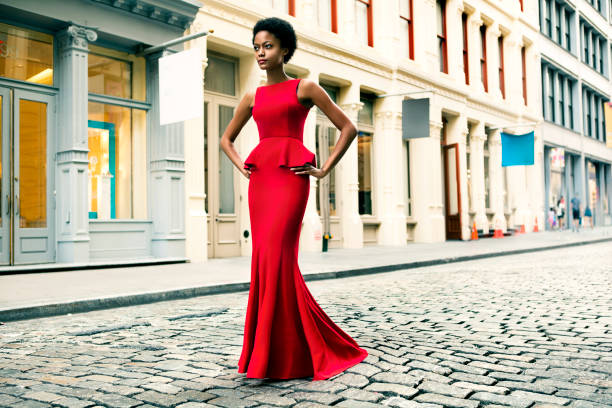

In [4]:
#original image
cv2_imshow(cv2.imread('/content/istockphoto-186543936-612x612.jpg'))

Downloading: "https://github.com/pytorch/vision/zipball/v0.6.0" to /root/.cache/torch/hub/v0.6.0.zip
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:04<00:00, 56.6MB/s]


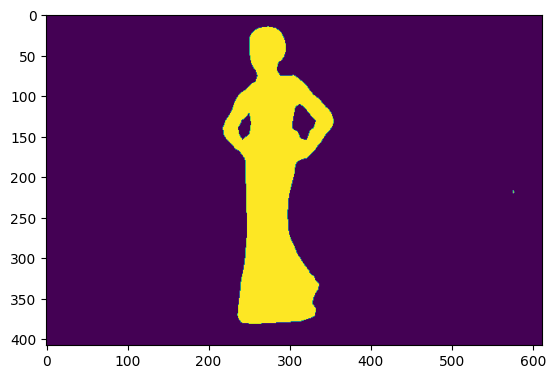

In [5]:
#loading the model
deeplab_model = load_model()
#remove the background
foreground, bin_mask = remove_background(deeplab_model, '/content/istockphoto-186543936-612x612.jpg')
#display mask
plt.imshow(bin_mask)

Now we plot/display the `foreground` array returned. It shows the transparent foreground image with the background successfully removed. Cool! 

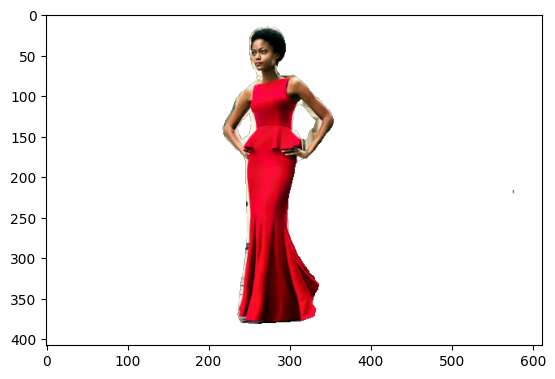

In [6]:
plt.imshow(foreground)

We can now use PIL (the image library) to save the `foreground` numpy array that we have created to a `.png` file. We can use this image as a transparent background `.png` as it has a proper alpha channel (for transparency) now and we have removed the background.

In [7]:
Image.fromarray(foreground).save("/content/foreground.png")

Now we write a new function to take a background file we downloaded and paste the transparent `foreground` numpy array we have created on it to superimpose them.

In [8]:
def custom_background(background_file, foreground):
  final_foreground = Image.fromarray(foreground)
  background = Image.open(background_file)
  x = (background.size[0]-final_foreground.size[0])/2
  y = (background.size[1]-final_foreground.size[1])/2
  box = (x, y, final_foreground.size[0] + x, final_foreground.size[1] + y)
  crop = background.crop(box)
  final_image = crop.copy()
  # put the foreground in the centre of the background
  paste_box = (0, final_image.size[1] - final_foreground.size[1], final_image.size[0], final_image.size[1])
  final_image.paste(final_foreground, paste_box, mask=final_foreground)
  return final_image

We run the `custom_background` function we wrote and plot/display the new output image.

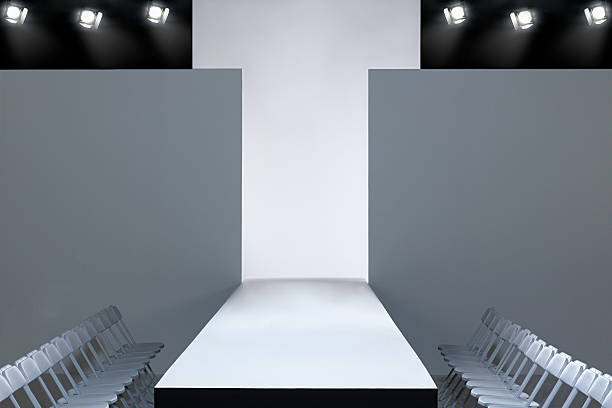

In [9]:
#background image to replace with
cv2_imshow(cv2.imread('/content/ramp.jpg'))

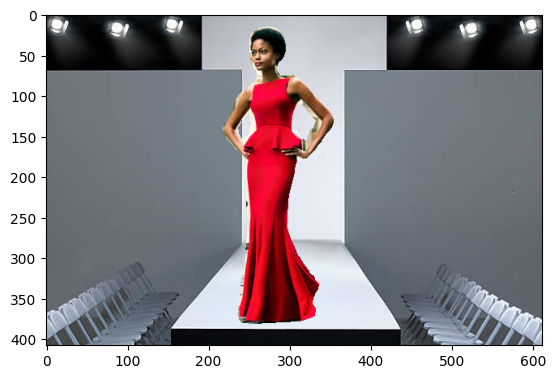

In [10]:
final_image = custom_background('/content/ramp.jpg', foreground)
plt.imshow(final_image)

Finally, we save this image to our local storage with the `.save(file_location)` function. We can either download it from here or transfer it to our Google Drive.

In [11]:
final_image.save("/content/final.jpg")